# Diff DNA Figure

Here we provide the code for the diff DNA figure in the paper.

In [2]:
import numpy as np
import pandas as pd
import pickle
import re

with open('data/ai_ecosystem_graph_finetune_fulljson.pkl', 'rb') as f:
    G = pickle.load(f)

successors = list(G.successors('Qwen/Qwen1.5-72B'))
print(successors)

str1 = G.nodes['Qwen/Qwen1.5-72B']['full_json']
str2 = G.nodes['abideen/MegaQwen-120B']['full_json']
print(str1)
print(str2)

['Qwen/Qwen1.5-72B-Chat', 'nisten/shqiponja-90', 'abideen/MegaQwen-120B']
{'_id': '65afd5fdaa335c2842e7f33c', 'id': 'Qwen/Qwen1.5-72B', 'likes': 60, 'trendingScore': 0, 'private': False, 'downloads': 10251, 'tags': ['transformers', 'safetensors', 'qwen2', 'text-generation', 'pretrained', 'conversational', 'en', 'arxiv:2309.16609', 'license:other', 'autotrain_compatible', 'text-generation-inference', 'endpoints_compatible', 'region:us'], 'pipeline_tag': 'text-generation', 'library_name': 'transformers', 'createdAt': '2024-01-23T15:06:37.000Z', 'modelId': 'Qwen/Qwen1.5-72B'}
{'_id': '65ec13dbceb1a8d208ee6b93', 'id': 'abideen/MegaQwen-120B', 'likes': 3, 'trendingScore': 0, 'private': False, 'downloads': 6, 'tags': ['transformers', 'safetensors', 'qwen2', 'text-generation', 'merge', 'mergekit', 'Qwen/Qwen1.5-72B', 'conversational', 'en', 'base_model:Qwen/Qwen1.5-72B', 'base_model:finetune:Qwen/Qwen1.5-72B', 'license:apache-2.0', 'autotrain_compatible', 'text-generation-inference', 'endpoin

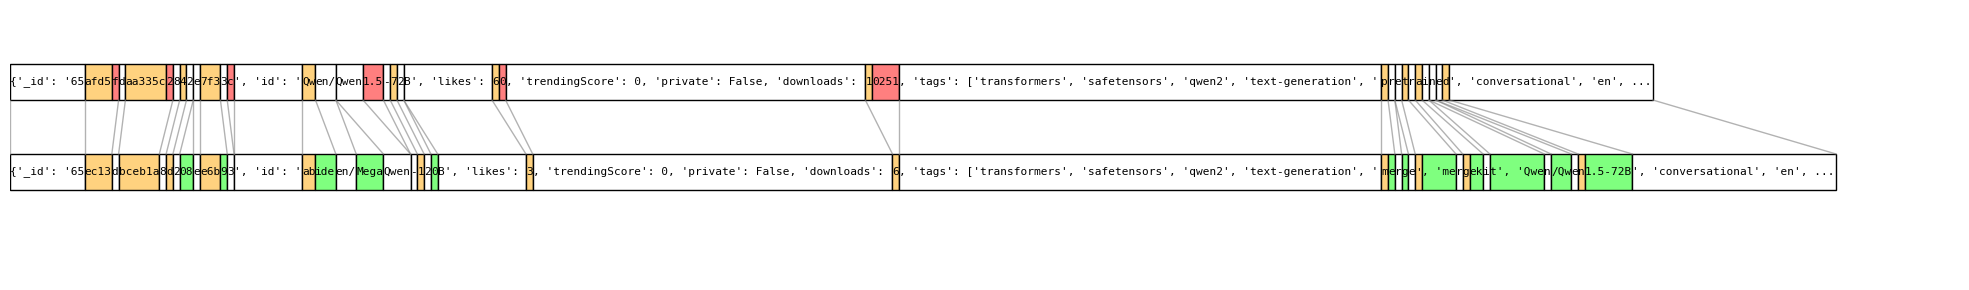

In [16]:
import matplotlib.pyplot as plt

def diff_segments(a: str, b: str):
    m, n = len(a), len(b)
    dp = [[0] * (n+1) for _ in range(m+1)]
    move = [[None] * (n+1) for _ in range(m+1)]

    # Init
    for i in range(m+1):
        dp[i][0] = i
        move[i][0] = 'del'
    for j in range(n+1):
        dp[0][j] = j
        move[0][j] = 'ins'
    move[0][0] = None

    # DP fill
    for i in range(1, m+1):
        for j in range(1, n+1):
            if a[i-1] == b[j-1]:
                dp[i][j] = dp[i-1][j-1]
                move[i][j] = 'eq'
            else:
                del_cost = dp[i-1][j] + 1
                ins_cost = dp[i][j-1] + 1
                rep_cost = dp[i-1][j-1] + 1
                dp[i][j], move[i][j] = min(
                    (del_cost, 'del'),
                    (ins_cost, 'ins'),
                    (rep_cost, 'rep')
                )

    # Traceback → segments
    i, j = m, n
    segments = []
    current_a = []
    current_b = []
    current_type = None

    def flush():
        nonlocal current_a, current_b, current_type
        if current_type:
            segments.append({
                'type': current_type,
                'a_str': ''.join(reversed(current_a)),
                'b_str': ''.join(reversed(current_b))
            })
        current_a, current_b, current_type = [], [], None

    while i > 0 or j > 0:
        tag = move[i][j]
        if tag == 'eq':
            if current_type != 'eq':
                flush()
                current_type = 'eq'
            i, j = i-1, j-1
            current_a.append(a[i])
            current_b.append(b[j])
        elif tag == 'rep':
            if current_type != 'rep':
                flush()
                current_type = 'rep'
            i, j = i-1, j-1
            current_a.append(a[i])
            current_b.append(b[j])
        elif tag == 'del':
            if current_type != 'del':
                flush()
                current_type = 'del'
            i -= 1
            current_a.append(a[i])
        elif tag == 'ins':
            if current_type != 'ins':
                flush()
                current_type = 'ins'
            j -= 1
            current_b.append(b[j])

    flush()
    segments.reverse()
    return segments

def plot_diff_segments(a: str, b: str, fig_name: str):
    segs = diff_segments(a, b)

    # CONFIGURATION
    char_width = 0.055#1      # Fixed width per character
    char_height = 0.4     # Box height
    y_parent = 2.0
    y_child = 1.0
    font = 'DejaVu Sans Mono'  # or 'Courier New'

    fig_width = max(len(a), len(b)) * char_width + 5
    fig, ax = plt.subplots(figsize=(fig_width, 3))
    ax.axis('off')

    parent_pos = 0.0
    child_pos = 0.0

    for seg in segs:
        seg_type = seg['type']
        a_len = len(seg['a_str'])
        b_len = len(seg['b_str'])
        a_width = a_len * char_width
        b_width = b_len * char_width

        color = {
            'eq': 'white',
            'rep': '#ffd27f',   # orange
            'del': '#ff7f7f',   # red
            'ins': '#7fff7f'    # green
        }[seg_type]

        # Draw parent segment
        if a_len > 0:
            ax.add_patch(plt.Rectangle(
                (parent_pos, y_parent),
                a_width, char_height,
                facecolor=color, edgecolor='black'
            ))
            ax.text(
                parent_pos, y_parent + char_height / 2,
                seg['a_str'],
                va='center', ha='left', fontsize=8, fontfamily=font
            )
            parent_left = parent_pos
            parent_right = parent_pos + a_width
        else:
            parent_left = parent_right = None

        # Draw child segment
        if b_len > 0:
            ax.add_patch(plt.Rectangle(
                (child_pos, y_child),
                b_width, char_height,
                facecolor=color, edgecolor='black'
            ))
            ax.text(
                child_pos, y_child + char_height / 2,
                seg['b_str'],
                va='center', ha='left', fontsize=8, fontfamily=font
            )
            child_left = child_pos
            child_right = child_pos + b_width
        else:
            child_left = child_right = None

        # Draw connector lines for equal segments
        if seg_type == 'eq' and a_len > 0 and b_len > 0:
            ax.plot(
                [parent_left, child_left],
                [y_parent, y_child + char_height],
                color='gray', linewidth=1, alpha=0.6
            )
            ax.plot(
                [parent_right, child_right],
                [y_parent, y_child + char_height],
                color='gray', linewidth=1, alpha=0.6
            )

        # Advance positions
        parent_pos += a_width
        child_pos += b_width

    ax.set_xlim(0, max(parent_pos, child_pos) + 1)
    ax.set_ylim(0, 3)
    plt.tight_layout()
    plt.savefig(f'figures/{fig_name}.png', dpi=400, bbox_inches='tight')
    plt.show()


#plot_diff_segments(parent, child, 'diff_full')
plot_diff_segments(str1[:239] + '...', str2[:266] + '...', 'diff_shorter')